# Layered objects examples
*Author: Niels Jeppesen (niejep@dtu.dk)*

**NOTICE:** This notebook assumes you are familiar with the basic concept of layered surface detection introduced in the *DetectLayers* notebook. 

Load essential modules for loading and showing data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

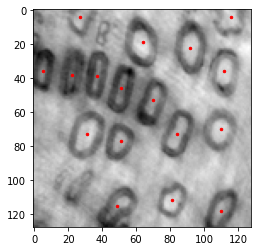

Number of objects: 17


In [2]:
# Load data.
path = './data/nerves.png'
data = imread(path).astype(np.int32)
data_centers = imread(path.replace('nerves', 'nerves_centers'))

# Get center positions.
centers = np.transpose(np.where(data_centers))

# Show image with centers.
plt.imshow(data, cmap='gray')
plt.scatter(centers[..., 1], centers[..., 0], color='red', s=6)
plt.show()

print('Number of objects:', len(centers))

## Unfolding
To detect the objects (nerves) using layered surface detection, we first need to unfold the nerves using a radial resampling.

In [3]:
from scipy.ndimage.interpolation import map_coordinates

def unfold_image(img, center, max_dists=None, r_min=1, r_max=20, angles=30, steps=15):

    # Sampling angles and radii.
    angles = np.linspace(0, 2*np.pi, angles, endpoint=False)
    distances = np.linspace(r_min, r_max, steps, endpoint=True)
    
    if max_dists is not None:
        max_dists.append(np.max(distances))
    
    # Get angles.
    angles_cos = np.cos(angles)
    angles_sin = np.sin(angles)
    
    # Calculate points positions.
    x_pos = center[0] + np.outer(angles_cos, distances)
    y_pos = center[1] + np.outer(angles_sin, distances)
    
    # Create list of sampling points.
    sampling_points = np.array([x_pos, y_pos]).transpose()
    sampling_shape = sampling_points.shape
    sampling_points_flat = sampling_points.reshape((-1, 2))
    
    # Sample from image.
    samples = map_coordinates(img, sampling_points_flat.transpose(), mode='nearest')
    samples = samples.reshape(sampling_shape[:2])
        
    return samples, sampling_points

Now that we have a function for unfolding image data, let's test it. The result should be an unfolded image, for which we can use layer detection.

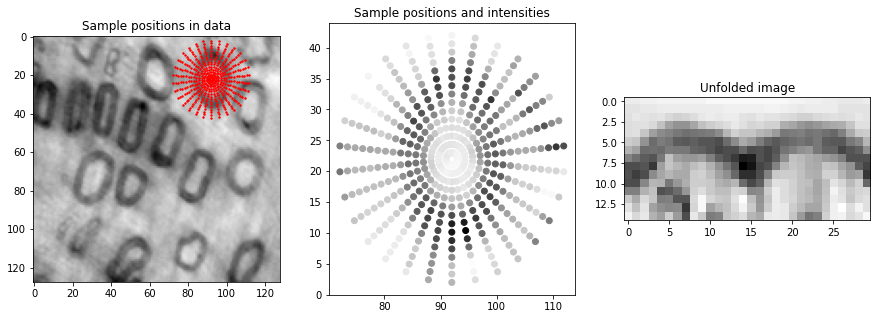

In [4]:
samples, sample_points = unfold_image(data, centers[3])

plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1, title='Sample positions in data')
ax.imshow(data, cmap='gray')
ax.scatter(sample_points[..., 1], sample_points[..., 0], s=2, color='red')
ax = plt.subplot(1, 3, 2, title='Sample positions and intensities')
ax.scatter(sample_points[..., 1], sample_points[..., 0], c=samples, cmap='gray')
ax = plt.subplot(1, 3, 3, title='Unfolded image')
ax.imshow(samples, cmap='gray')
plt.show()

## Detect layers in object
Now that we can unfold the nerves, we can try to use graph cut based layer detection, as introduced in the previous notebook.

Since we want to separate the inner and outer part of the nerve, we will detect two layers per nerve. We will use the gradient image for this.

In [5]:
from slgbuilder import GraphObject, MaxflowBuilder

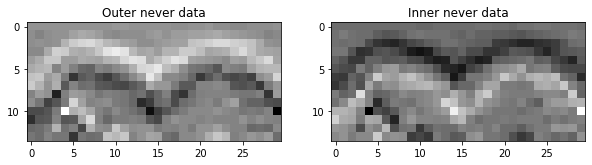

In [6]:
# Create gradient-based objects.
diff_samples = np.diff(samples, axis=0)
outer_nerve = GraphObject(255 - diff_samples)
inner_nerve = GraphObject(diff_samples)

# Show object data.
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1, title='Outer never data')
ax.imshow(outer_nerve.data, cmap='gray')
ax = plt.subplot(1, 2, 2, title='Inner never data')
ax.imshow(inner_nerve.data, cmap='gray')
plt.show()

The surface will be detected where the data pixel intensity in the images are low. This corresponds well with the data for the outer and inner nerves shown above.

Let's detect the layers. We apply boundary cost, smoothness and containment constraints. Here we set both ```min_margin``` and ```max_margin``` constraints for our containment. Then we use ```maxflow``` to find the optimal solution.

In [7]:
helper = MaxflowBuilder()
helper.add_objects([outer_nerve, inner_nerve])
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)
helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)

In [8]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 1454


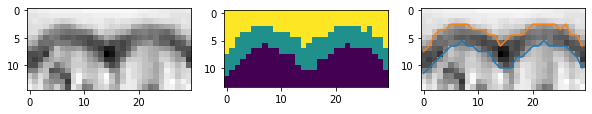

In [9]:
segmentations = [helper.get_labels(o).astype(np.int32) for o in helper.objects]
segmentation_lines = [np.count_nonzero(s, axis=0) - 0.5 for s in segmentations]

# Draw results.
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 3, 1)
ax.imshow(samples, cmap='gray')
ax = plt.subplot(1, 3, 2)
ax.imshow(np.sum(segmentations, axis=0))
ax = plt.subplot(1, 3, 3)
ax.imshow(samples, cmap='gray')
for line in segmentation_lines:
    ax.plot(line)
plt.show()

Since we have the original positions (in the original image) for each pixel in our unfolded image, we can easily map the segmentation back to our real data. We will do this later.

## Detecting multiple objects
In the image data, we have marked 17 different nerves that we would like to segment. We could segment each of these individually, the same way we segmented the single nerve above. Although it is not the most memory efficient way of segmenting the objects, we could also just add all the objects to the graph at once and get a segmentation for each object. This creates a graph with many "layers", each representing nodes for an object. Because the nodes in each layers only represent a subset of the original image pixels, we call this a Sparse Layered Graph (SLG).

In [10]:
# Lists for storing nerve objects.
nerve_samples = []
outer_nerves = []
inner_nerves = []

# For each center, create an inner and outer never.
for center in centers:
    # Unfold nerve.
    samples, sample_points = unfold_image(data, center)
    nerve_samples.append(samples)
    
    # Create outer and inner nerve objects.
    diff_samples = np.diff(samples, axis=0)
    diff_sample_points = sample_points[:-1]
    
    outer_nerves.append(GraphObject(255 - diff_samples, diff_sample_points))
    inner_nerves.append(GraphObject(diff_samples, diff_sample_points))

Here we also add the sample positions to the ```GraphObject```s. We will need these later.

In [11]:
helper = MaxflowBuilder()
helper.add_objects(outer_nerves + inner_nerves)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)

In [12]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 24219


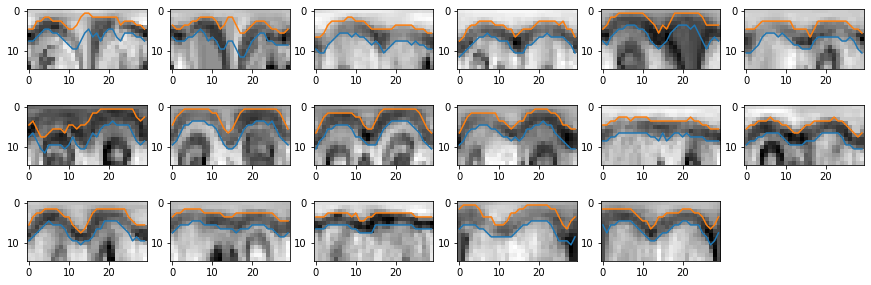

In [13]:
# Get segmentations.
segmentations = []
for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    segmentations.append(helper.get_labels(outer_nerve))
    segmentations.append(helper.get_labels(inner_nerve))

segmentation_lines = [np.count_nonzero(s, axis=0) - 0.5 for s in segmentations]

# Draw segmentations.
plt.figure(figsize=(15, 5))
for i, samples in enumerate(nerve_samples):
    ax = plt.subplot(3, len(nerve_samples) // 3 + 1, i + 1)
    ax.imshow(samples, cmap='gray')
    
    ax.plot(segmentation_lines[2*i])
    ax.plot(segmentation_lines[2*i + 1])

plt.show()

While most of the segmentations went well, if we look closely we see that some don't look right. If we draw the lines on the original image, we see the problem.

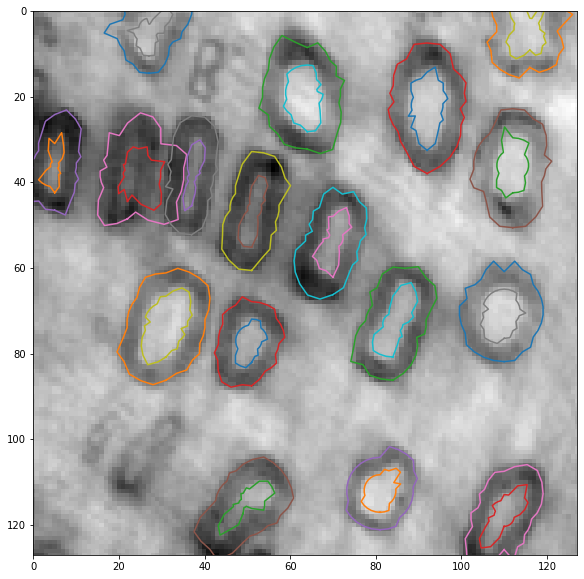

In [14]:
def draw_segmentations(data, helper):
    """Draw all segmentations for objects in the helper on top of the data."""
    
    # Create figure.
    plt.figure(figsize=(10, 10))
    plt.imshow(data, cmap='gray')
    plt.xlim([0, data.shape[1]-1])
    plt.ylim([data.shape[0]-1, 0])

    # Draw segmentation lines.
    for i, obj in enumerate(helper.objects):

        # Get segmentation.
        segment = helper.get_labels(obj)

        # Create line.
        line = np.count_nonzero(segment, axis=0)

        # Get actual points.
        point_indices = tuple(np.asarray([line - 1, np.arange(len(line))]))
        points = obj.sample_points[point_indices]
        # Close line.
        points = np.append(points, points[:1], axis=0)

        # Plot points.
        plt.plot(points[..., 1], points[..., 0])

    plt.show()
    
draw_segmentations(data, helper)

One of the objects is segmented incorrectly overlapping the neighbouring segmentations.

## Multi-object exclusion
To overcome the issue of overlapping segments, we can add exclusion contraints between all outer nerves. However, exclusion is a so-called *nonsubmodular* energy term, which means it cannot be represented as a single edge in our graph. Luckily there's an algorithm called *QPBO* (Qudratic Pseudo-Boolean Optimization) that can help us. 

QPBO creates a complementary graph, alongside the original graph. The complementary graph is inverted, meaning that is has the exact same edges as the original graph, except they are reversed. This means that the graph size is doubled, which makes computation slower and uses more memory. The benefit of QPBO is that we can now add nonsubmodular energies such as exclusion. When coupled with the sparse layered graph structure, we are able to segment many interacting objects using both containment and exclusion interactions.

The ```slgbuilder``` module contains a ```QPBOBuilder``` class, which is very similar to the ```MaxflowBuilder``` we've been using so far. The main difference is that it has functions for adding exclusion. One of these is ```add_layered_exclusion``` which we will now use. We will be using the ```GraphObject```s created earlier.

In [15]:
from slgbuilder import QPBOBuilder

In [16]:
helper = QPBOBuilder()
helper.add_objects(outer_nerves + inner_nerves)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)

In [17]:
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)

if 2*flow == twice_flow:
    print('QPBO flow is exactly twice the Maxflow flow.')
else:
    print('Something is wrong...')

Two times maximum flow/minimum energy: 48438
QPBO flow is exactly twice the Maxflow flow.


We see that the ```QPBOBuilder``` energy/flow is exactly twice the flow computed by ```MaxflowBuilder``` for a similar problem, which is what we expect, since we double the number of nodes and edges. This is because we have added exactly the same edges/energies on above. This of course also means that the segmentation is exactly the same, hence we haven't fixed the problem yet. 

To avoid the overlapping nerve segments, we add exclusion between all *outer* nerve objects using ```add_layered_exclusion``` and call ```solve``` again. Note that calculating the new maxflow/mincut only requires us to re-evaluate parts of the graph that were changed, potentially making the computation very fast.

In [18]:
# Add exclusion constraints between all pairs of outer nerves.
for i in range(len(outer_nerves)):
    for j in range(i + 1, len(outer_nerves)):
        helper.add_layered_exclusion(outer_nerves[i], outer_nerves[j], margin=3)

In [19]:
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)

Two times maximum flow/minimum energy: 48580


We see that adding the new constraints has increased the energy. This makes sense, since our constraints are forcing a solution that is less optimal from the perspective of the data. However, our prior knowledge tells us that nerves cannot overlap, so even if the data suggest that they do, we know this is not the case, but rather because the data is inaccurate.

Let's draw the segmentation results with exclusion inteactions.

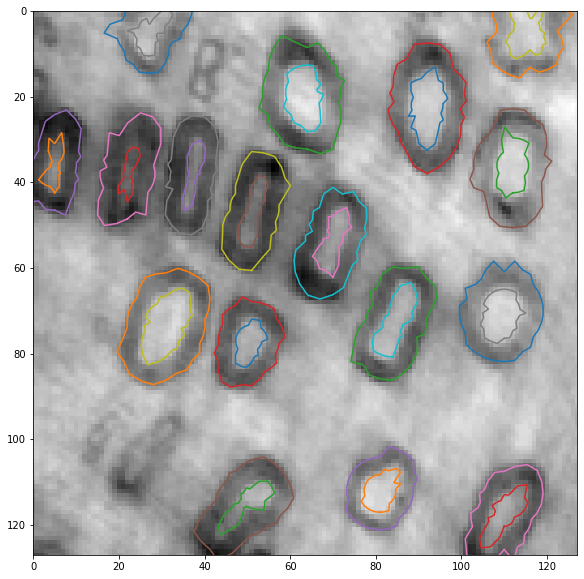

In [20]:
draw_segmentations(data, helper)

## Region cost
So far we've only been using the gradient of the data in our model. However, the pixel intensity may also provide valuable information. In this segmentation problem we notice that each region (area between the layers/object boundaries) has different mean intensities. Generally the nerves are blight inside, while the outer part in dark. The background is also bright.

If the mean intensities of the different objects are relatively consistent, we can use the intensities in our model. We've been using the ordered multi-column graph structure by [Li et al](https://doi.org/10.1109/TPAMI.2006.19). To use the intensities, we use the region cost approach by [Haeker et al](https://doi.org/10.1007/978-3-540-73273-0_50).

We will add the region cost to our existing model and see how it changes the segmentation. The ```beta``` value is used to scale the influence of the region information compared to the gradient information previously added through the ```add_layered_boundary_cost```. To add region cost for an object we use the ```add_layered_region_cost```.

In [21]:
mu_inside = 90
mu_ring = 70
mu_outside = 90
beta = 0.1

for samples, outer_nerve, inner_nerve in zip(nerve_samples, outer_nerves, inner_nerves):
    samples = samples[:-1]
    
    inside_cost = np.abs(samples - mu_inside) * beta
    ring_cost = np.abs(samples - mu_ring) * beta
    outside_cost = np.abs(samples - mu_outside) * beta
    
    helper.add_layered_region_cost(inner_nerve, ring_cost, inside_cost)
    helper.add_layered_region_cost(outer_nerve, outside_cost, ring_cost)

In [22]:
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)

Two times maximum flow/minimum energy: 63572


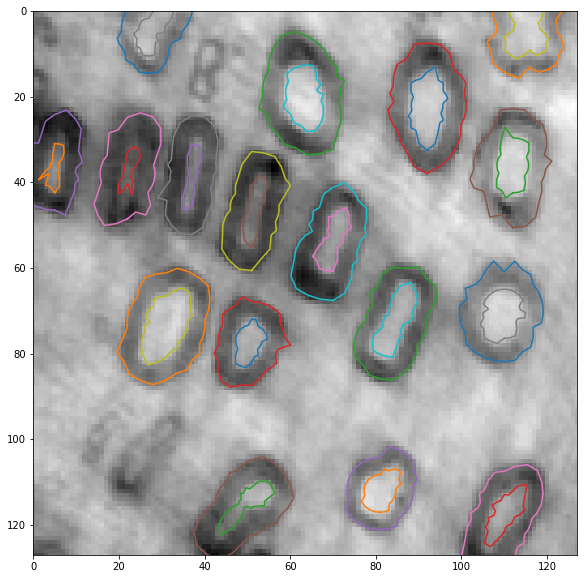

In [23]:
draw_segmentations(data, helper)

In some areas the results improve slightly, however for areas where the intensities are far from the mean instensities of the region the region cost may lead to a less accurate segmentation.